In [42]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from itertools import product
from rs.LightFMRecommender import LightFMRecommender

In [2]:
data = pd.read_csv('./data/retail_train.csv')

item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [16]:
no_components_vals = [10, 40, 80, 120, 200]
loss_vals= ["bpr", "warp"] #"logistic", 
learning_rate_vals=[.005, .01, .05, .1]
results = pd.DataFrame()

# прифильтрация данных
data_train_filtered = LightFMRecommender.filter_data(data_train, take_n_popular=5000, item_features=item_features)

# тестовые результаты для вычисления метрики
test_result = data_test.groupby('user_id')['item_id'].unique().reset_index()
test_result.columns=['user_id', 'actual']

# исследуемые параметры
grid = list(product(no_components_vals, loss_vals, learning_rate_vals))

# получение метрик для каждой комбинации параметров
for params in  grid:
    
    # инициализация модели
    lightfm_recommender = LightFMRecommender(no_components=params[0],
                                             loss=params[1], 
                                             learning_rate=params[2])

    # обучение модели
    lightfm_recommender.fit(data=data_train_filtered, user_features=user_features, item_features=item_features, verbose=False)
    
    # предсказания модели
    data_train_filtered['score'] = lightfm_recommender.predict()
    
    # подготовка датафрейма для рассчета метрики
    predict_result = data_train_filtered[['user_id','item_id','score']][data_train_filtered.item_id != lightfm_recommender.filtered_id].\
        drop_duplicates().sort_values(by=['user_id','score'], ascending=False).groupby('user_id')['item_id'].unique().reset_index()
    
    df_result_for_metrics = test_result.merge(predict_result, on='user_id', how='inner')
    
    # вычисление метрики precision_at_k
    precision = lightfm_recommender.precision_at_k(df_result_for_metrics, k=5)
    
    # сохранение результатов
    results = results.append({'no_components':params[0], 'loss_vals':params[1], 'learning_rate':params[2], 'precision_at_k':precision}, ignore_index = True)

##### Вывод результатов

In [17]:
results.sort_values('precision_at_k', ascending=False, inplace=True)  
results

,no_components,loss_vals,learning_rate,precision_at_k
32,200.0,bpr,0.005,0.146535
13,40.0,warp,0.010,0.146240
33,200.0,bpr,0.010,0.145846
25,120.0,bpr,0.010,0.144565
35,200.0,bpr,0.100,0.144466
24,120.0,bpr,0.005,0.144466
17,80.0,bpr,0.010,0.142989
6,10.0,warp,0.050,0.142693
16,80.0,bpr,0.005,0.142693
0,10.0,bpr,0.005,0.142299


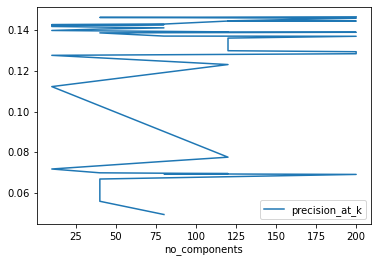

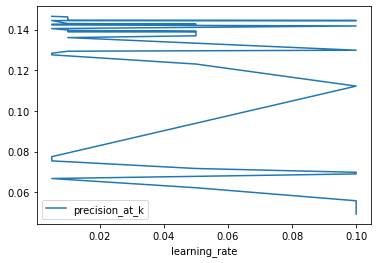

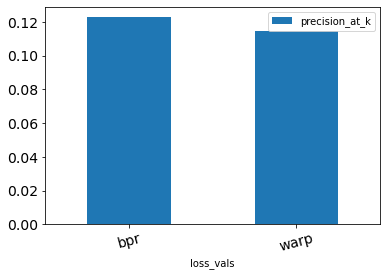

In [41]:
results.plot(x='no_components', y="precision_at_k")
results.plot(x='learning_rate', y="precision_at_k")
mean_prec = results.groupby(['loss_vals']).mean().plot(y="precision_at_k", kind="bar", rot=15, fontsize=14)

#### Можно сделать вывод, что прямой зависимости метрики precision_at_k от отдельно взятых парметров LightFM нет. Использование функции потерь bpr даёт лучшие показатели метрики чем warp.

При параметре функции потерь loss_vals="logistic" появляется ошибка, указанная в ячейке ниже. Причину не удалось выяснить.

ValueError                                Traceback (most recent call last)
~\AppData\Local\Temp/ipykernel_21972/3193310547.py in <module>
     23     print(params)
     24 
---> 25     lightfm_recommender.fit(data=data_train_filtered, user_features=user_features, item_features=item_features, verbose=False)
     26 
     27     data_train_filtered['score'] = lightfm_recommender.predict()

~\JupyterRoot\RecommenderSystems\webinar_5\rs\LightFMRecommender.py in fit(self, data, user_features, item_features, epochs, num_threads, verbose)
     64             self.item_feat_lightfm = self.__prepare_item_features(item_features)
     65 
---> 66             self.model.fit((self.sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
     67                       sample_weight=coo_matrix(self.user_item_matrix),
     68                       user_features=csr_matrix(self.user_feat_lightfm.values).tocsr(),

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\lightfm.py in fit(self, interactions, user_features, item_features, sample_weight, epochs, num_threads, verbose)
    531         self._reset_state()
    532 
--> 533         return self.fit_partial(
    534             interactions,
    535             user_features=user_features,

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\lightfm.py in fit_partial(self, interactions, user_features, item_features, sample_weight, epochs, num_threads, verbose)
    645             )
    646 
--> 647             self._check_finite()
    648 
    649         return self

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\lightfm.py in _check_finite(self)
    440             # large boolean temporary.
    441             if not np.isfinite(np.sum(parameter)):
--> 442                 raise ValueError(
    443                     "Not all estimated parameters are finite,"
    444                     " your model may have diverged. Try decreasing"

ValueError: Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights